In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import optimize, stats

In [2]:
def load_prices(path):
    df = pd.read_csv(path, header=[0, 1], skiprows=[2], index_col=0)
    df.index = pd.to_datetime(df.index)
    df = df.sort_index()
    df = df["Adj Close"]
    df = df[~df.index.duplicated(keep="last")]
    df = df.astype(float)
    df = df.ffill()
    return df

In [14]:
path = "data/prices.csv"
    
config = {
    "tickers": [
        "SPY", "IWM", "EFA", "EEM", "AGG", "TLT", 
        "LQD", "HYG", "EMB", "GLD", "DBC", "VNQ"
    ],
    "start": "2005-01-01",
    "end": None,
    "rebalance_freq": "W-FRI",
    "transaction_cost_bps": 10,
    "top_k": 5,
    "risk_window_days": 252,
    "dual_mom_signal": "ret_12_1m",
}

In [15]:
prices = load_prices(path)

if config["end"] is None:
    prices = prices.loc[config["start"]:]
else:
    prices = prices.loc[config["start"]:config["end"]]

prices = prices[config["tickers"]]

daily_ret = prices.pct_change()
month_end_prices = prices.resample(config["rebalance_freq"]).last()
monthly_ret = month_end_prices.pct_change()


In [16]:
freq = config["rebalance_freq"]
rebal_dates = month_end_prices.index


In [17]:
ret_12_1m_daily = prices.shift(21) / prices.shift(252) - 1
ret_12_1m = ret_12_1m_daily.reindex(rebal_dates, method="ffill")
signals = {"ret_12_1m": ret_12_1m,}


In [18]:
def dual_mom_score(rel_score: pd.DataFrame, abs_score: pd.DataFrame) -> pd.DataFrame:
    score = rel_score.copy()
    score = score.where(abs_score > 0)
    return score

_dm_base = signals[config["dual_mom_signal"]]
dual_mom_score_df = dual_mom_score(_dm_base, _dm_base)

In [19]:
strategies = {}
strategies["DualMom"] = {"scores": dual_mom_score_df, "mode": "relative"}

In [20]:
def inverse_vol_weights(cov: pd.DataFrame) -> pd.Series:
    vol = np.sqrt(np.diag(cov.values))
    inv = 1 / np.where(vol == 0, np.nan, vol)
    w = inv / np.nansum(inv)
    return pd.Series(w, index=cov.index)

def build_weights(score_df: pd.DataFrame, mode: str, name: str) -> pd.DataFrame:
    tickers = config["tickers"]
    w = pd.DataFrame(0.0, index=score_df.index, columns=tickers)
    for dt in score_df.index:
        score = score_df.loc[dt].dropna()
        if score.empty:
            continue

        if mode == "absolute":
            eligible = score[score > 0].index
        elif mode == "relative":
            eligible = score.sort_values(ascending=False).head(config["top_k"]).index
        else:
            raise ValueError("Unknown mode")
        
        if len(eligible) == 0:
            continue

        hist = daily_ret.loc[:dt].tail(config["risk_window_days"])
        hist = hist[eligible].dropna(how="all")
        cov = hist.cov()
        cov = cov.loc[eligible, eligible]
        cov = cov.dropna(axis=0, how="all").dropna(axis=1, how="all")
        if cov.shape[0] == 0:
            continue
        cov = cov.fillna(0.0)
        cov = cov + np.eye(cov.shape[0]) * 1e-6

        try:
            weights = inverse_vol_weights(cov)
        except Exception:
            weights = pd.Series(1.0 / len(eligible), index=eligible)
        
        weights = weights / weights.sum()
        w.loc[dt, weights.index] = weights.values
    return w

weights = {}
for name, spec in strategies.items():
    w = build_weights(spec["scores"], spec["mode"], name)
    weights[name] = w

In [21]:
results = {}
turnovers = {}

N = len(config["tickers"])
w_eqw = pd.DataFrame(1.0 / N, index=monthly_ret.index, columns=config["tickers"])

all_weights = dict(weights)
all_weights["EQW"] = w_eqw

for name, w in all_weights.items():
    w = w.reindex(monthly_ret.index).fillna(0.0)
    gross = (w.shift(1) * monthly_ret).sum(axis=1)
    turnover = w.diff().abs().sum(axis=1)
    cost = turnover.shift(1) * (config["transaction_cost_bps"] / 10000.0)
    net = gross - cost
    results[name] = net
    turnovers[name] = turnover

returns_df = pd.DataFrame(results)

In [22]:
def max_drawdown(nav: pd.Series) -> tuple[float, int]:
    hwm = nav.cummax()
    dd = nav / hwm - 1.0
    max_dd = dd.min()

    duration = 0
    max_duration = 0
    for v in dd:
        if v < 0:
            duration += 1
        else:
            duration = 0
        max_duration = max(max_duration, duration)

    return float(max_dd), int(max_duration)

def perf_stats(returns: pd.Series, periods_per_year: int = 12) -> dict:
    r = returns.dropna()
    if r.empty:
        return {k: np.nan for k in ["AnnReturn", "CAGR", "Vol", "Sharpe", "MaxDD", "MaxDDDur", "Skew", "Kurtosis", "HitRate"]}

    ann_ret = r.mean() * periods_per_year
    cagr = (1 + r).prod() ** (periods_per_year / len(r)) - 1
    vol = r.std(ddof=1) * np.sqrt(periods_per_year)
    sharpe = ann_ret / vol if vol != 0 else np.nan

    nav = (1 + r).cumprod()
    max_dd, max_dd_dur = max_drawdown(nav)

    skew = stats.skew(r)
    kurt = stats.kurtosis(r, fisher=True)
    hit = (r >= 0).mean()

    return {
        "AnnReturn": ann_ret,
        "CAGR": cagr,
        "Vol": vol,
        "Sharpe": sharpe,
        "MaxDD": max_dd,
        "MaxDDDur": max_dd_dur,
        "Skew": skew,
        "Kurtosis": kurt,
        "HitRate": hit,
    }

perf = pd.DataFrame({name: perf_stats(returns_df[name]) for name in returns_df.columns}).T
perf = perf.sort_values("Sharpe", ascending=False)
perf

,AnnReturn,CAGR,Vol,Sharpe,MaxDD,MaxDDDur,Skew,Kurtosis,HitRate
EQW,0.016805,0.015538,0.052303,0.321309,-0.342667,139.0,-0.768161,11.757962,0.570391
DualMom,0.014484,0.012905,0.057489,0.251948,-0.292884,200.0,-0.216884,6.599731,0.596730


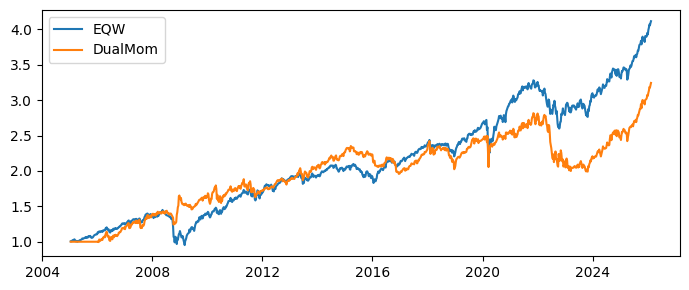

In [23]:
perf_sorted = perf.copy()
cols = list(perf_sorted.head(5).index)
if "EQW" not in cols:
    cols.append("EQW")

cum = (1 + returns_df[cols]).cumprod()
fig, ax = plt.subplots(figsize=(7, 3), tight_layout=True)
for col in cum.columns:
    ax.plot(cum.index, cum[col], label=col)
ax.legend()
plt.show()

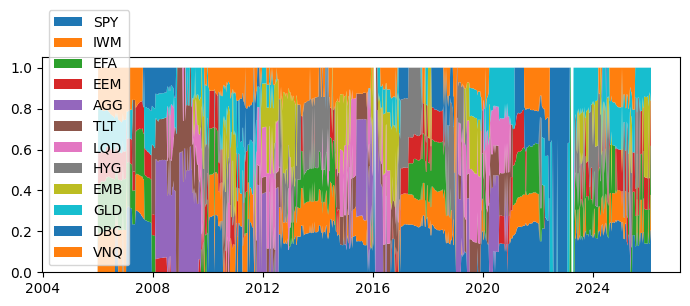

In [24]:
fig, ax = plt.subplots(figsize=(7, 3), tight_layout=True)
ax.stackplot(
    weights["DualMom"].index, 
    weights["DualMom"].T, 
    labels=weights["DualMom"].columns
)
ax.legend()
plt.show()